In [17]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data
from src.plotting_functions import *
import os
import json
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import (
    linkage,
    fcluster,
    dendrogram,
    leaves_list,
    set_link_color_palette,
)
from matplotlib import colors
from nilearn.image import iter_img
import seaborn as sns

In [18]:
project_path = "/workspaces/bha2"
CONN_SIZE = 2165

In [19]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(CONN_SIZE), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(CONN_SIZE), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [20]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [21]:
initial_parcellation = nib.load(os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(CONN_SIZE),
        "initial_partition.nii.gz",
    ))
initial_parcellation_data = initial_parcellation.get_fdata()

In [22]:
TREE_MIN = 2
TREE_MAX = 200
SM_THRESH = 5
OPT_GAMMA = 0.7
OPT_LEVEL = 28
tree = json.loads(
                    open(
                        os.path.join(
                            project_path,
                            "data",
                            "processed",
                            "n" + str(CONN_SIZE),
                            "tree_g_" + str(OPT_GAMMA) + ".json",
                        )
                    ).read()
)
opt_level_modules, opt_level_labels = level_from_tree(tree, OPT_LEVEL)
opt_level_module_sizes = np.array([len(x) for x in opt_level_modules])

In [23]:
color_list = []
for name, hex in colors.cnames.items():
    rgb = colors.hex2color(hex)
    L = pow((pow(rgb[0], 2) + pow(rgb[1], 2) + pow(rgb[2], 2)), 0.5) / pow(3, 0.5)
    if L < 0.85:
        color_list.append(name)
np.random.seed(3)
color_list = list(np.random.choice(color_list, OPT_LEVEL, replace=False))
#remove from the list colors corresponding to one-roi modules
color_list_dend = np.delete(color_list, np.where(opt_level_module_sizes == 1)[0]).tolist()
color_list_ni = np.delete(color_list, np.where(opt_level_module_sizes < SM_THRESH)[0]).tolist()

/tmp/ipykernel_987/3071892074.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cc, "weighted", "correlation")


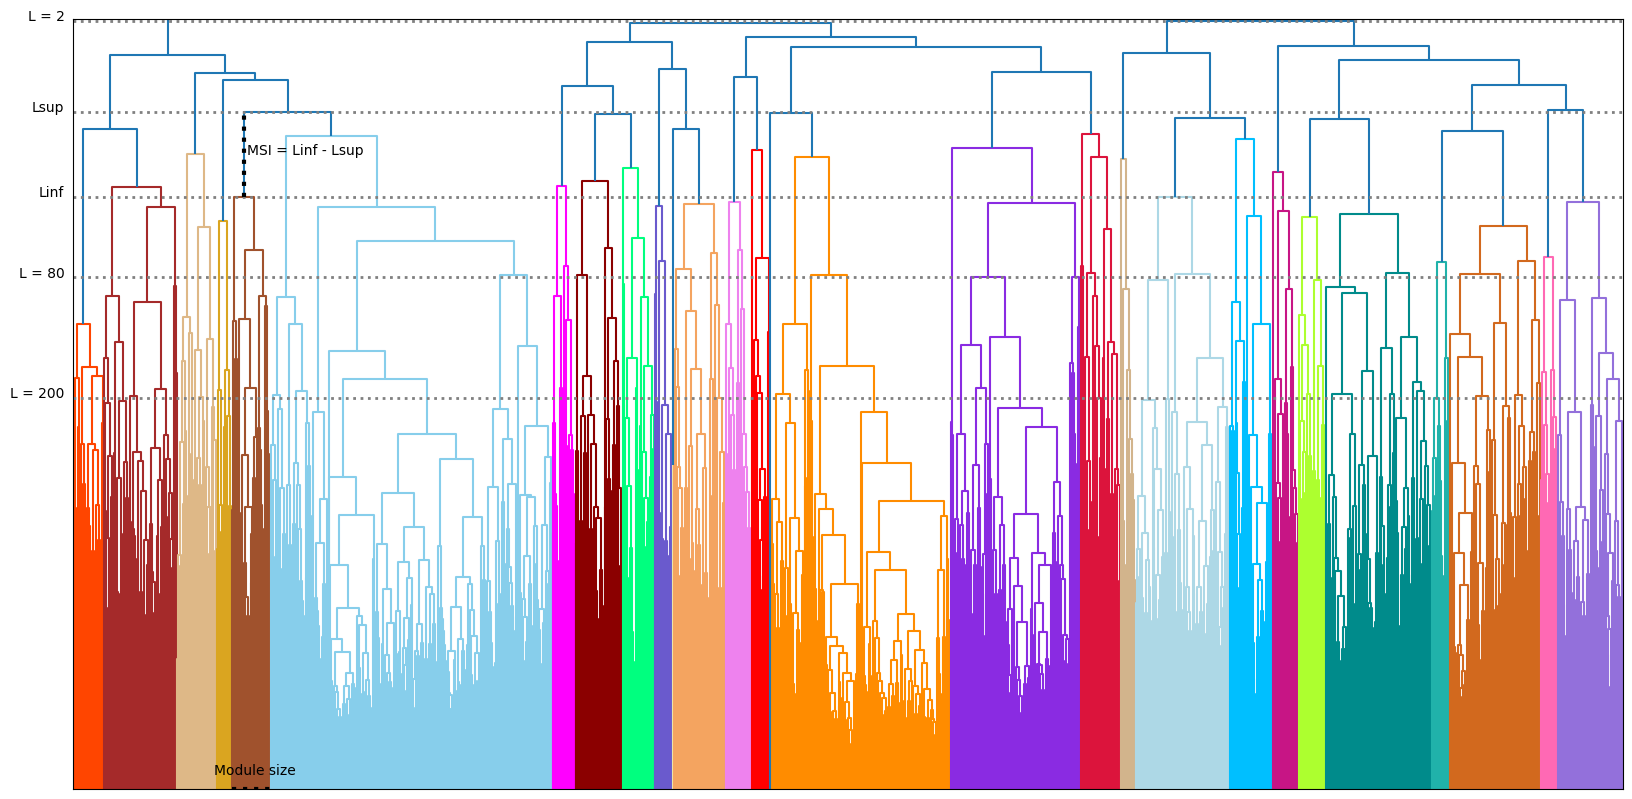

In [40]:
plt.figure(figsize=(20, 10))
cc = matrix_fusion(OPT_GAMMA,fcm_bin, scm_bin)
Z = linkage(cc, "weighted", "correlation")
height_in_tree_sorted = Z[:, 2][::-1]

set_link_color_palette(color_list_dend)
den = dendrogram(
    Z, color_threshold=height_in_tree_sorted[OPT_LEVEL - 2], no_labels=True
)
plt.ylim(0, 1)
plt.yticks([])

# draw some examples of levels
plot_hline_dend(height_in_tree_sorted[2], "L = 2")
plot_hline_dend(height_in_tree_sorted[80], "L = 80")
plot_hline_dend(height_in_tree_sorted[200], "L = 200")

# draw the meanings of MSI and module size for module 5
module_selected = 5

module_rois = tree["lvl_" + str(OPT_LEVEL) + "_mod_" + str(module_selected)]
module_presence_in_tree = []
for l in range(2, 200):
    level, labels = level_from_tree(tree, l)
    for module in level:
        if module == module_rois:
            module_presence_in_tree.append(l)
            break
lvl_bf_module = min(module_presence_in_tree) - 2
lvl_af_module = max(module_presence_in_tree) - 1
height_af = height_in_tree_sorted[lvl_af_module]
height_bf = height_in_tree_sorted[lvl_bf_module]
x_loc, y_loc = np.where(np.array(den["dcoord"]) == height_af)
x = den["icoord"][x_loc[2]][y_loc[2]]

plot_hline_dend(height_bf, "Lsup")
plot_hline_dend(height_af, "Linf")
plot_vline_dend(x, height_bf, height_af, "MSI = Linf - Lsup")
plot_module_size_dend(Z, module_rois, den)

plt.savefig(
    os.path.join(project_path, "data", "figures", "opt_parcell_tree.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

(25, 2140)


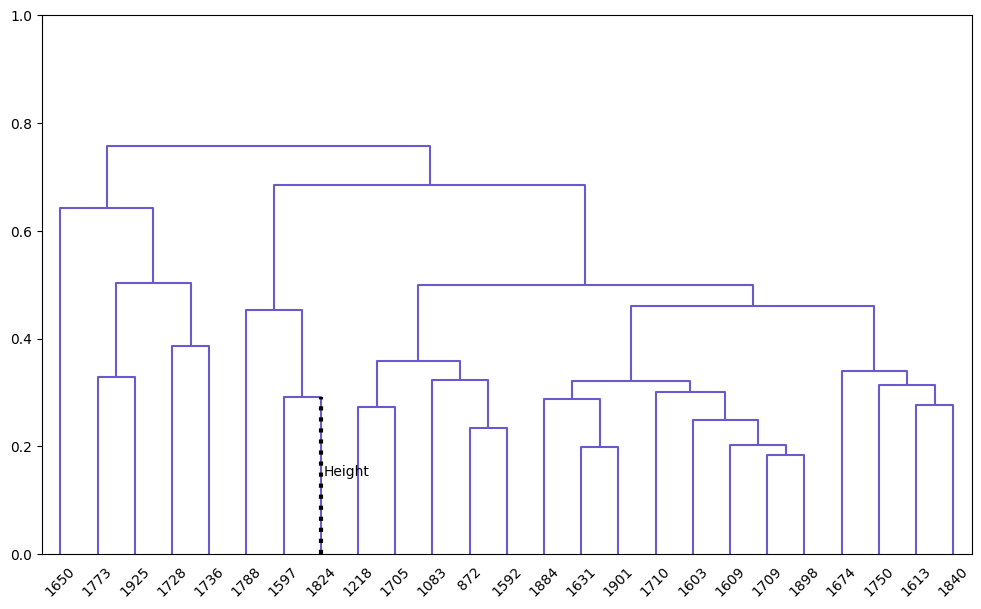

In [25]:
plt.figure(figsize=(12, 7))
leaves = leaves_list(Z)
height_in_tree_nosorted = np.hstack((1, Z[:, 2]))
module_selected = 10

module_rois = tree["lvl_" + str(OPT_LEVEL) + "_mod_" + str(module_selected)]
loc_in_tree = np.where(np.in1d(leaves, module_rois))[0]
subtree_color = den["leaves_color_list"][loc_in_tree[0]]

cc_mod = matrix_fusion(OPT_GAMMA, fcm_bin[module_rois, :], scm_bin[module_rois, :])
Z_mod = linkage(cc_mod, "weighted", "correlation")
height_in_tree_sorted_mod = Z_mod[:, 2][::-1]
print(cc_mod.shape)

# Plot the new dendrogram
den_mod = dendrogram(
    Z_mod, color_threshold=0, above_threshold_color=subtree_color, labels=module_rois
)
plt.ylim(0, 1)

leaves_first_list_sorted_mod = Z_mod[:, 0][::-1].astype(int)
leaves_second_list_sorted_mod = Z_mod[:, 1][::-1].astype(int)

# draw the meaning of height for roi 4, roi 4 is module_rois[4]
roi_selected = 19
idx_in_first_list_mod = np.where(leaves_first_list_sorted_mod == roi_selected)[0]
idx_in_second_list_mod = np.where(leaves_second_list_sorted_mod == roi_selected)[0]
if idx_in_first_list_mod.size > 0:
    roi_height = height_in_tree_sorted_mod[idx_in_first_list_mod[0]]
    x_loc, y_loc = np.where(np.array(den_mod["dcoord"]) == roi_height)
    x = den_mod["icoord"][x_loc[0]][y_loc[0]]
elif idx_in_second_list_mod.size > 0:
    roi_height = height_in_tree_sorted_mod[idx_in_second_list_mod[0]]
    x_loc, y_loc = np.where(np.array(den_mod["dcoord"]) == roi_height)
    x = den_mod["icoord"][x_loc[0]][y_loc[1]]

plot_vline_dend(x, roi_height, 0, "Height")

plt.savefig(
    os.path.join(
        project_path, "data", "figures", "opt_parcell_mod_inset_example.svg"
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

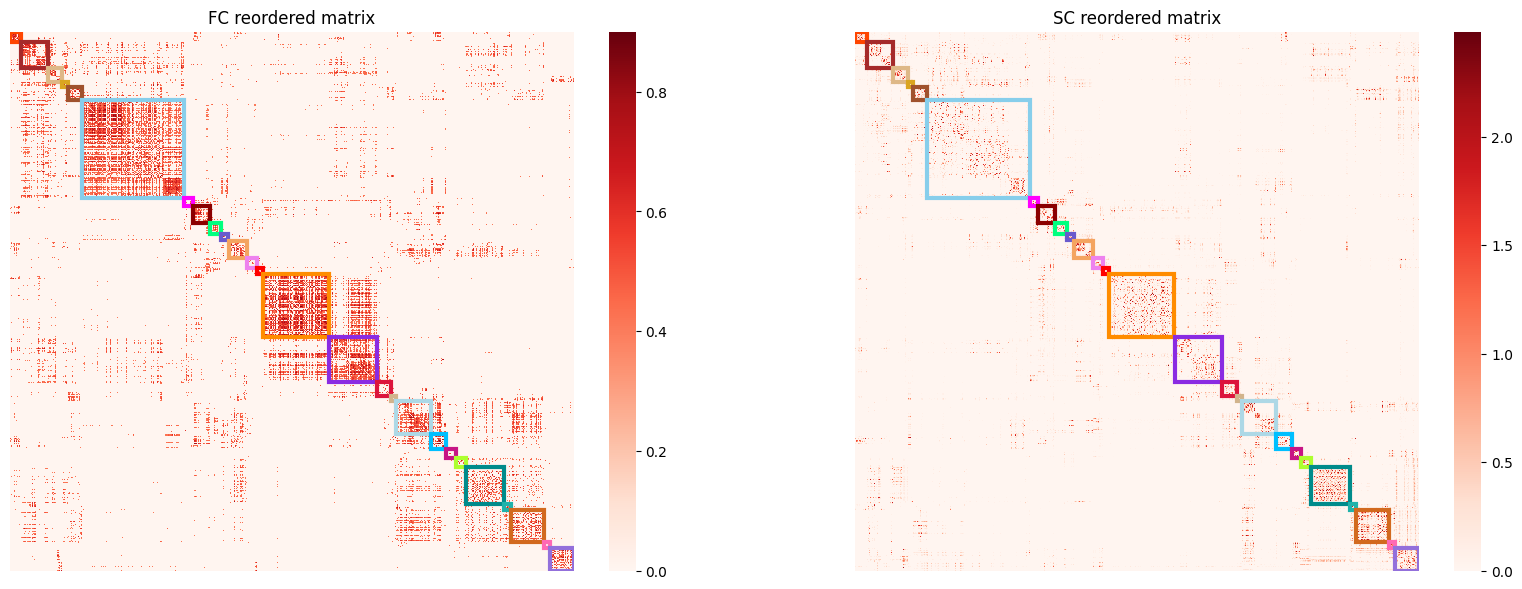

In [26]:
fcm_nonzero_reordered = np.zeros(fcm_nonzero.shape)
scm_nonzero_reordered = np.zeros(scm_nonzero.shape)
fcm_nonzero_reordered = fcm_nonzero[np.hstack(opt_level_modules), :]
fcm_nonzero_reordered = fcm_nonzero_reordered[:, np.hstack(opt_level_modules)]
scm_nonzero_reordered = scm_nonzero[np.hstack(opt_level_modules), :]
scm_nonzero_reordered = scm_nonzero_reordered[:, np.hstack(opt_level_modules)]



plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(fcm_nonzero_reordered, ax=ax[0], cmap="Reds")
ax[0].set_title("FC reordered matrix")
    
sns.heatmap(np.log10(scm_nonzero_reordered+1), ax=ax[1], cmap="Reds")
ax[1].set_title("SC reordered matrix")

idx = 0
for i in range(len(opt_level_module_sizes)):
    if opt_level_module_sizes[i] > SM_THRESH:
        rect_pos=np.sum(opt_level_module_sizes[:i])
        ax[0].add_patch(plt.Rectangle((rect_pos, rect_pos), opt_level_module_sizes[i], opt_level_module_sizes[i], fill=False, edgecolor=color_list_ni[idx], lw=3))
        ax[1].add_patch(plt.Rectangle((rect_pos, rect_pos), opt_level_module_sizes[i], opt_level_module_sizes[i], fill=False, edgecolor=color_list_ni[idx], lw=3))
        idx += 1

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.savefig(
    os.path.join(
        project_path, "data", "figures", "connectome_reordered.png"
    ),
    dpi=300,
    bbox_inches="tight",
    format="png",
)

/usr/local/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


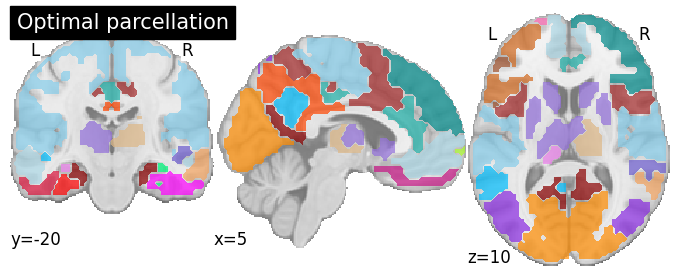

In [27]:
mni_bg = plotting.plot_anat(
    cut_coords=[5, -20, 10],
    black_bg=False,
    draw_cross=False,
    title="Optimal parcellation",
)

idx = 0
for rois in opt_level_modules:
    if len(rois) > SM_THRESH:
        mod = get_module_vol(initial_parcellation, rois)
        mod_img = nib.Nifti1Image(mod.astype(float), affine=initial_parcellation.affine)
        mni_bg.add_contours(
            mod_img, linewidths=2.0, levels=[0.01], filled=True, alpha=0.7, colors=color_list_ni[idx]
        )
        idx += 1

plt.savefig(
    os.path.join(project_path, "data", "figures", "opt_parcell_brain.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

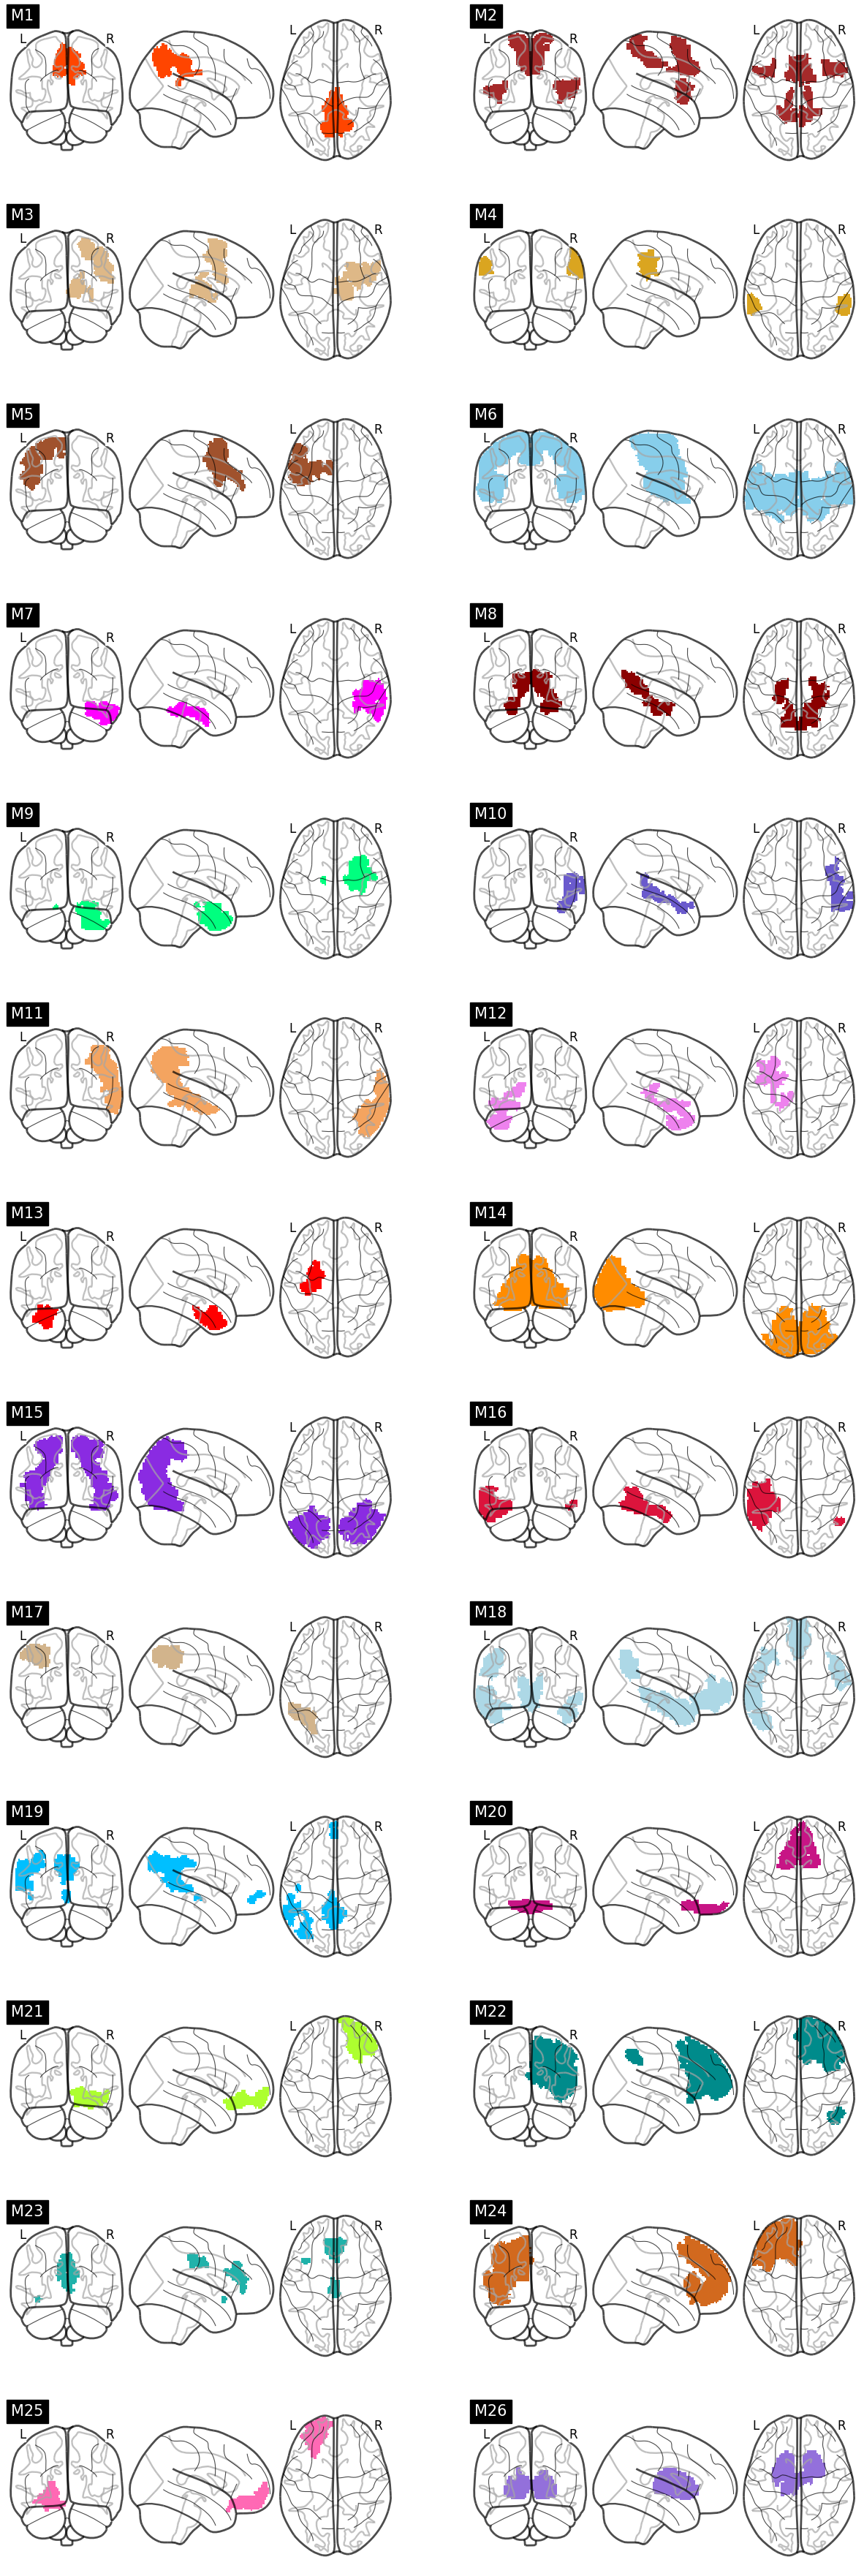

In [28]:
number_of_valid_modules = sum(opt_level_module_sizes>SM_THRESH)
fig = plt.figure(figsize=(15,int((number_of_valid_modules)/2 + 0.5)*3.5))

idx = 0
for rois in opt_level_modules:
    if len(rois) > SM_THRESH:
        ax = fig.add_subplot(int((number_of_valid_modules)/2 + 0.5), 2, idx+1)
        mod = get_module_vol(initial_parcellation, rois)
        mod_img = nib.Nifti1Image(mod.astype(float), affine=initial_parcellation.affine)
        plotting.plot_glass_brain(
                mod_img,
                colorbar=False,
                cmap = colors.ListedColormap(color_list_ni[idx]),
                title="M" + str(idx+1),
                axes=ax,
            )
        idx += 1

plt.savefig(
        os.path.join(project_path, "data", "figures", "optimal_parcellation_module_bglass.svg"),
        dpi=300,
        bbox_inches="tight",
        format="svg",
    )

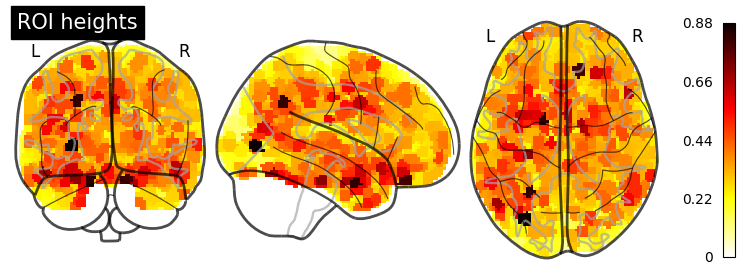

In [29]:
roi_break_heights = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
leaves_first_list_sorted = Z[:, 0][::-1].astype(int)
leaves_second_list_sorted = Z[:, 1][::-1].astype(int)

roi_heights = []
for roi in range(fcm_bin.shape[1]):
    idx_in_first_list = np.where(leaves_first_list_sorted == roi)[0]
    idx_in_second_list = np.where(leaves_second_list_sorted == roi)[0]
    if idx_in_first_list.size > 0:
        roi_break_heights = roi_break_heights + get_module_vol(
            initial_parcellation, roi, height_in_tree_sorted[idx_in_first_list[0]]
        )
        roi_heights.append(height_in_tree_sorted[idx_in_first_list[0]])
    elif idx_in_second_list.size > 0:
        roi_break_heights = roi_break_heights + get_module_vol(
            initial_parcellation, roi, height_in_tree_sorted[idx_in_second_list[0]]
        )
        roi_heights.append(height_in_tree_sorted[idx_in_second_list[0]])
    else:
        print("roi " + str(roi) + " not found")

plotting.plot_glass_brain(
    nib.Nifti1Image(roi_break_heights, affine=initial_parcellation.affine),
    colorbar=True,
    title="ROI heights",
)

nib.save(
    nib.Nifti1Image(roi_break_heights, affine=initial_parcellation.affine),
    os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(CONN_SIZE),
        "roi_breaks_heights.nii.gz",
    ),
)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


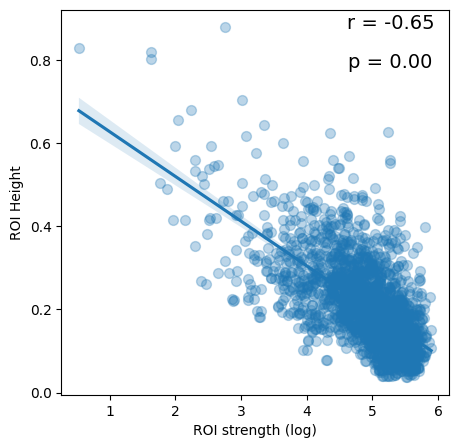

In [30]:
plt.figure(figsize=(5, 5))

cc = (OPT_GAMMA * fcm_bin) + ((1 - OPT_GAMMA) * scm_bin)
strength_fullmat = cc.sum(axis=0, dtype=float)
sns.regplot(np.log(strength_fullmat), roi_heights, scatter_kws={'alpha':0.3, 's': 50})
plt.xlabel("ROI strength (log)")
plt.ylabel("ROI Height")
plot_corr(np.log(strength_fullmat), roi_heights, 0.85, 0.85)

plt.savefig(
        os.path.join(project_path, "data", "figures", "ROI height_vs_strength.svg"),
        dpi=300,
        bbox_inches="tight",
        format="svg",
    )

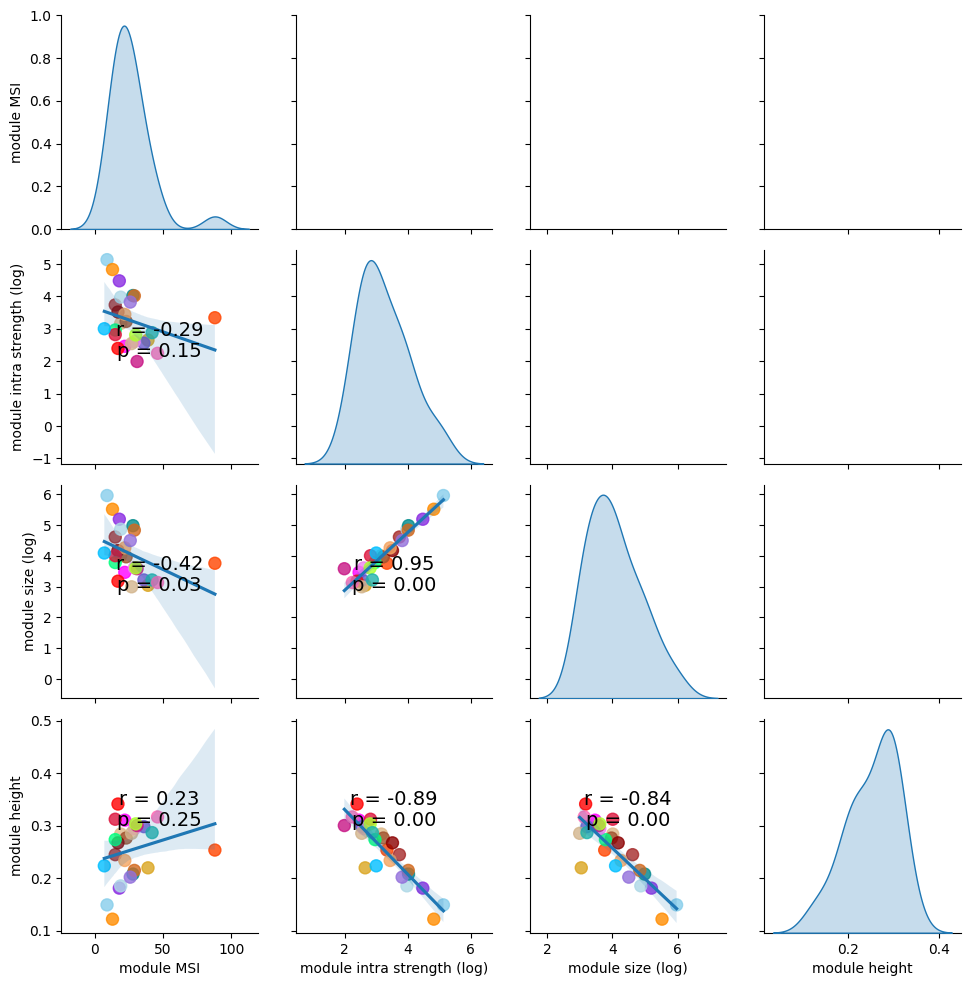

In [39]:
module_MSI = []
module_size = []
module_mean_heights = []
module_intra_strength = []

for module_indices in range(1, OPT_LEVEL + 1):
    module_rois = tree["lvl_" + str(OPT_LEVEL) + "_mod_" + str(module_indices)]
    if len(module_rois) > SM_THRESH:
        cc = (OPT_GAMMA * fcm_bin) + ((1 - OPT_GAMMA) * scm_bin)
        module_intra_strength.append(cc[module_rois, :][:, module_rois].sum(dtype=float)/len(module_rois))
        heights_from_first_list = height_in_tree_sorted[
            np.where(np.in1d(leaves_first_list_sorted, module_rois))[0]
        ]
        heights_from_second_list = height_in_tree_sorted[
            np.where(np.in1d(leaves_second_list_sorted, module_rois))[0]
        ]
        module_mean_heights.append(
            np.mean(np.hstack((heights_from_first_list, heights_from_second_list)))
        )
        module_presence_in_tree = []
        for l in range(2, 200):
            level, labels = level_from_tree(tree, l)
            for module in level:
                if module == module_rois:
                    module_presence_in_tree.append(l)
                    break

        module_MSI.append(len(module_presence_in_tree))
        module_size.append(len(module_rois))


module_measures = pd.DataFrame({"module MSI": module_MSI, 
    "module intra strength (log)": np.log(module_intra_strength),
    "module size (log)": np.log(module_size), 
    "module height": module_mean_heights})
#sns.pairplot(module_measures, diag_kind="kde", corner=True)


correlogram = sns.PairGrid(module_measures, diag_sharey=False)

correlogram.map_lower(sns.regplot, scatter_kws={'alpha':0.8, 's': 75, 'color': color_list_ni})
correlogram.map_lower(plot_corr)
correlogram.map_diag(sns.kdeplot, shade=True)
correlogram.savefig(
        os.path.join(project_path, "data", "figures", "dendrogram_variables_correlogram.svg"),
        dpi=300,
        bbox_inches="tight",
        format="svg",
    )

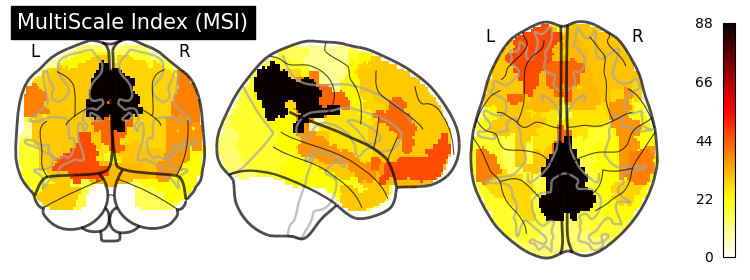

In [38]:
module_MSI_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
idx = 0
for module_indices in range(1, OPT_LEVEL + 1):
    module_rois = tree["lvl_" + str(OPT_LEVEL) + "_mod_" + str(module_indices)]
    if len(module_rois) > 5:
        module_MSI_img = module_MSI_img + get_module_vol(
            initial_parcellation, module_rois, module_MSI[idx]
        )
        idx += 1
plotting.plot_glass_brain(
    nib.Nifti1Image(module_MSI_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="MultiScale Index (MSI)",
)
plt.savefig(
    os.path.join(
        project_path, "data", "figures", "opt_parcell_module_MSI_brain.svg"
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)
nib.save(
    nib.Nifti1Image(module_MSI_img, affine=initial_parcellation.affine),
    os.path.join(project_path, "data", "processed", "n" + str(CONN_SIZE), "MSI.nii.gz"),
)

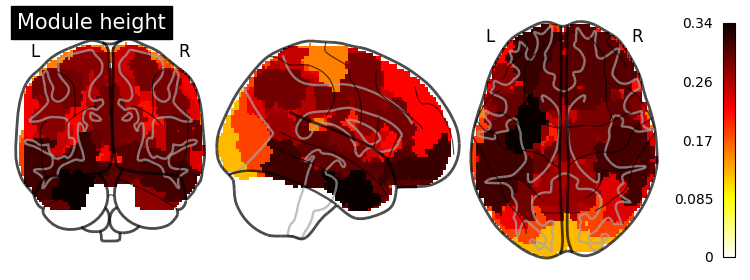

In [15]:
module_heights_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
idx = 0
for module_indices in range(1, OPT_LEVEL + 1):
    module_rois = tree["lvl_" + str(OPT_LEVEL) + "_mod_" + str(module_indices)]
    if len(module_rois) > 5:
        module_heights_img = module_heights_img + get_module_vol(
            initial_parcellation, module_rois, module_mean_heights[idx]
        )
        idx += 1
plotting.plot_glass_brain(
    nib.Nifti1Image(module_heights_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="Module height",
)
nib.save(
    nib.Nifti1Image(module_heights_img, affine=initial_parcellation.affine),
    os.path.join(
        project_path, "data", "processed", "n" + str(CONN_SIZE), "module_height.nii.gz"
    ),
)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "opt_parcell_module_height_brain.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

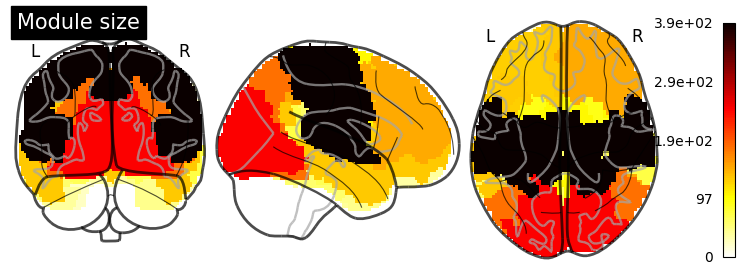

In [16]:
module_size_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
idx = 0
for module_indices in range(1, OPT_LEVEL + 1):
    module_rois = tree["lvl_" + str(OPT_LEVEL) + "_mod_" + str(module_indices)]
    if len(module_rois) > 5:
        module_size_img = module_size_img + get_module_vol(
            initial_parcellation, module_rois, module_size[idx]
        )
        idx += 1
plotting.plot_glass_brain(
    nib.Nifti1Image(module_size_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="Module size",
)
nib.save(
    nib.Nifti1Image(module_size_img, affine=initial_parcellation.affine),
    os.path.join(
        project_path, "data", "processed", "n" + str(CONN_SIZE), "module_size.nii.gz"
    ),
)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "opt_parcell_module_size_brain.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

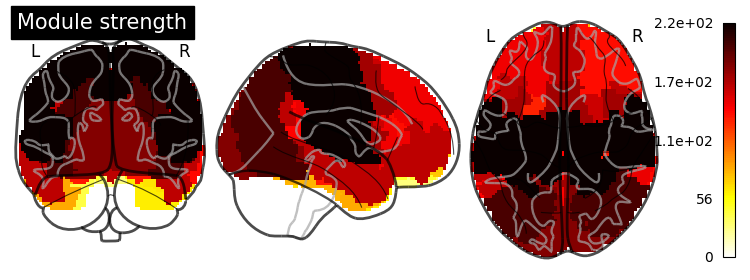

In [17]:
module_degree_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)

idx = 0
for module_indices in range(1, OPT_LEVEL + 1):
    module_rois = tree["lvl_" + str(OPT_LEVEL) + "_mod_" + str(module_indices)]
    if len(module_rois) > 5:
        module_degree_img = module_degree_img + get_module_vol(
            initial_parcellation, module_rois, module_mean_strength[idx]
        )
        idx += 1
plotting.plot_glass_brain(
    nib.Nifti1Image(module_degree_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="Module strength",
)
nib.save(
    nib.Nifti1Image(module_degree_img, affine=initial_parcellation.affine),
    os.path.join(
        project_path, "data", "processed", "n" + str(CONN_SIZE), "module_degree.nii.gz"
    ),
)